In [1]:
!pip install pandas scikit-learn nltk seaborn

import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# download required nltk data
nltk.download("all")


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [2]:
# 1. Load dataset

emails = pd.read_csv("spam.csv", encoding="latin-1")

emails = emails.rename(columns={emails.columns[0]: "label", emails.columns[1]: "message"})

In [3]:
# 2. Preprocessing

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_message(message):
    # lowercase
    message = message.lower()
    # remove punctuation
    message = "".join([ch for ch in message if ch not in string.punctuation])
    # tokenize
    words = nltk.word_tokenize(message)
    # remove stopwords + stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

emails["clean_message"] = emails["message"].apply(preprocess_message)


In [4]:
# 3. Features and Labels

labels = emails["label"].map({"ham": 0, "spam": 1})   # 0 = ham, 1 = spam
messages = emails["clean_message"]

vectorizer = CountVectorizer(max_features=5000)
features = vectorizer.fit_transform(messages)


📌 Spam Detection Results (Naive Bayes):
              precision    recall  f1-score   support

         Ham       0.97      0.99      0.98      4247
        Spam       0.94      0.82      0.87       657

    accuracy                           0.97      4904
   macro avg       0.95      0.90      0.93      4904
weighted avg       0.97      0.97      0.97      4904



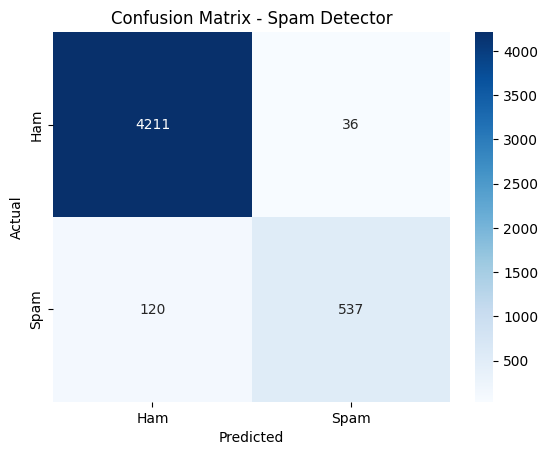

In [32]:
# 4. Train-Test Split

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# 5. Train Model

spam_detector = MultinomialNB()
spam_detector.fit(train_features, train_labels)


# 6. Predictions & Evaluation

predicted_labels = spam_detector.predict(test_features)

print("📌 Spam Detection Results (Naive Bayes):")
print(classification_report(test_labels, predicted_labels, target_names=["Ham", "Spam"]))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Spam Detector")
plt.show()

In [21]:
print("Total messages:", len(labels))
print("Training set:", len(train_labels))
print("Test set:", len(test_labels))

Total messages: 5572
Training set: 5014
Test set: 558


In [41]:
# 7. Test on new messages

# read messages from a txt file
with open("email.txt", "r", encoding="utf-8") as f:
    test_samples = [line.strip() for line in f.readlines() if line.strip()]

# preprocess and predict
test_samples_cleaned = [preprocess_message(msg) for msg in test_samples]

test_features = vectorizer.transform(test_samples_cleaned)
predictions = spam_detector.predict(test_features)

# show results
for msg, pred in zip(test_samples, predictions):
    print(f"Message: {msg}")
    print("Prediction:", "Spam " if pred == 1 else "Ham ")
    print("-" * 50)


Message: Congratulations! You won a free ticket. Claim now!
Prediction: Spam 
--------------------------------------------------
Message: Hey, are we still meeting for lunch tomorrow?
Prediction: Ham 
--------------------------------------------------
Message: URGENT! Your account will be suspended unless you verify now.
Prediction: Spam 
--------------------------------------------------
Message: jkdsjlkjdslksdjflkjdsf
Prediction: Ham 
--------------------------------------------------
Message: fjjdkjf hi
Prediction: Ham 
--------------------------------------------------
Message: hola
Prediction: Ham 
--------------------------------------------------
Message: indain siddiq
Prediction: Ham 
--------------------------------------------------
Message: nai mamam kana mamamCongratulations! You won a free ticket. Claim now!
Prediction: Spam 
--------------------------------------------------
Message: Hey, are we still meeting for lunch tomorrow?
Prediction: Ham 
--------------------------

In [42]:

test_samples_cleaned = [preprocess_message(msg) for msg in test_samples]

for msg, clean_msg in zip(test_samples, test_samples_cleaned):
    vec = vectorizer.transform([clean_msg])

    if vec.nnz == 0:  # nnz = number of non-zero entries
        print(f"Message: {msg}")
        print("Prediction: ⚠️ Cannot classify (no known words)")
    else:
        pred = spam_detector.predict(vec)[0]
        print(f"Message: {msg}")
        print("Prediction:", "Spam 🚨" if pred == 1 else "Ham ✅")

    print("-" * 50)


Message: Congratulations! You won a free ticket. Claim now!
Prediction: Spam 🚨
--------------------------------------------------
Message: Hey, are we still meeting for lunch tomorrow?
Prediction: Ham ✅
--------------------------------------------------
Message: URGENT! Your account will be suspended unless you verify now.
Prediction: Spam 🚨
--------------------------------------------------
Message: jkdsjlkjdslksdjflkjdsf
Prediction: ⚠️ Cannot classify (no known words)
--------------------------------------------------
Message: fjjdkjf hi
Prediction: Ham ✅
--------------------------------------------------
Message: hola
Prediction: ⚠️ Cannot classify (no known words)
--------------------------------------------------
Message: indain siddiq
Prediction: ⚠️ Cannot classify (no known words)
--------------------------------------------------
Message: nai mamam kana mamamCongratulations! You won a free ticket. Claim now!
Prediction: Spam 🚨
--------------------------------------------------
